In [ ]:
# =======================================================
# Module 4: Business Analytics Model Development
# Project: Databricks-Enabled Procurement Analytics
# Author: Taiwo Babalola
# Dataset: abc_dw_gl_pr_po_kpi.csv (Gold Layer)
# Business Analytics Model for Classification and Regression
# =======================================================
# Data Review and Cleaning

# The dataset used in this notebook (`abc_dw_gl_pr_po_kpi.csv`) is the Gold-layer output from Milestone 1, where extensive cleaning, deduplication, date conversion, and KPI engineering were performed in Databricks.

# In this notebook, additional light cleaning is applied:
# - Filtering out rows with missing `sla_breach_flag` and `pr_to_po_ageing`.
# - Replacing missing numeric values with 0 for modeling.
# - Replacing missing categorical values with `"Unknown"`.

# This ensures the data is ready for model training and evaluation.

# -----------------------------
# 1. IMPORT LIBRARIES
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

pd.set_option("display.max_columns", None)



In [3]:
# -----------------------------
# 2. LOAD DATA
# -----------------------------
# **Load and review the Gold dataset** (`abc_dw_gl_pr_po_kpi.csv`) to confirm structure and key fields..
# Adjust the path as needed.
df = pd.read_csv("abc_dw_gl_pr_po_kpi.csv")

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (681, 80)


,pr_purchaserequisition,pr_itemnumber,pr_documenttype,pr_creationdate,pr_createdby_name,pr_approvalstatus,pr_approveddate,pr_processingstatus,pr_companycode,pr_companycodedesc,pr_plant,pr_plantdesc,pr_orderqty,pr_unitofmeasure,pr_closedindicator,pr_deletionindicator,pr_recordskipindicator,pr_lastchangedatetime,pr_silver_load_date,pr_silver_load_timestamp,purchaseorder,po_itemnumber,po_purchaserequisition,po_serialnumber,po_returnsitem,po_purchasingdoctype,po_purchasingdoctypedesc,po_purchasingdocdate,po_deletionindicator,po_purchasingorg,po_purchasingorgdesc,po_companycode,po_companycodedesc,po_purchasinggroup,po_purchasinggroupdesc,po_vendornumber,po_vendorname,po_vendoraccountgroup,po_vendoraccountgroupdesc,po_supplierclassification,po_countrykey,po_localorinternational,po_plant,po_plantdesc,po_storageloc,po_createdon,po_createdby_name,po_documentyear,po_accountassignmentcat,po_accountassignmentcatdesc,po_accntassignmentcatvaluedesc,po_version,po_processingstatuscode,po_processingstatus,po_postingdate,po_approvaldate,po_deliverydate,po_paymentdate,material,materialdesc,materialgroup,materialgroupdesc,materialtype,materialtypedesc,po_orderquantity,po_unitofmeasure,po_netamount,po_recordskipindicator,po_lastchangedatetime,po_silver_load_date,po_silver_load_timestamp,pr_to_po_ageing,pr_approval_ageing,po_approval_ageing,sla_breach_flag,pr_cycle_sla_breach_flag,po_cycle_sla_breach_flag,record_type,gold_load_date,gold_load_timestamp
0,2.000126e+09,480.0,ZNPR,2023-08-14,Tobi Emmaunel,Approved,2023-08-15,B-PO created,9900.0,ABC logistics Limited,9900.0,ABC logistics Limited - LAGOS,2.0,PAK,NaN,NaN,NaN,NaN,2025-11-24,2025-11-24T19:24:18.246Z,4.500229e+09,480.0,2.000126e+09,24378.0,NaN,ZLPO,Local PO,2023-10-10,NaN,9900.0,ABC logistics Limited Porg,9900.0,ABC Logistics Limited,215.0,Tobi Emmaunel,1.000019e+09,Maktabi Alhadeth Limited Co,Group A,Domestic Vendors/Sub-Contracto,External,GH,International,9900.0,ABC Logistics Limites - LAGOS,NaN,2023-10-10,Kazem Moustafa Badr Mohamed,2023.0,K,Cost center,ABC - LAG Division,1.0,5.0,05-Approved,2023-11-15,2023-10-19,2023-10-22,NaN,4.000000e+09,"SIGN PEN, PILOT V-SIGN, BLACK, 12 PCS/PA",G121130,Stationery Expenses,NLAG,Non-Stock Materials,2.0,PAK,62.72,NaN,NaN,2025-11-24,2025-11-24T19:24:13.818Z,41.0,2.0,8.0,YES,NO,YES,PR_PO_MATCHED,2025-11-24,2025-11-24T19:32:18.832Z
1,2.000130e+09,50.0,ZNPR,2023-09-09,Christian PAT,Approved,2023-09-14,B-PO created,9900.0,ABC logistics Limited,9900.0,ABC logistics Limited - LAGOS,50.0,PAK,NaN,NaN,NaN,NaN,2025-11-24,2025-11-24T19:24:18.246Z,4.500231e+09,50.0,2.000130e+09,24573.0,NaN,ZLPO,Local PO,2023-10-17,NaN,9900.0,ABC logistics Limited Porg,9900.0,ABC Logistics Limited,332.0,Christian PAT,1.000020e+09,Al Falah Advanced Trading,Group A,Domestic Vendors/Sub-Contracto,External,GH,International,9900.0,ABC Logistics Limites - LAGOS,1002.0,2023-10-17,Javed Ahmed Khan,2023.0,NaN,NaN,NaN,0.0,5.0,05-Approved,2023-10-25,2023-10-18,2023-10-21,NaN,1.000001e+11,"""BLADE, JIGSAW, NO. B 16 """"MAKITA"""" A-85684""",M031500,Accessories & Consumables,ZCON,Consumables,50.0,PAK,710.50,NaN,NaN,2025-11-24,2025-11-24T19:24:13.818Z,24.0,5.0,2.0,YES,YES,NO,PR_PO_MATCHED,2025-11-24,2025-11-24T19:32:18.832Z
2,2.000127e+09,10.0,ZNPR,2023-08-15,Christian PAT,Approved,2023-08-19,B-PO created,9900.0,ABC logistics Limited,9900.0,ABC logistics Limited - LAGOS,20.0,PAA,NaN,NaN,NaN,NaN,2025-11-24,2025-11-24T19:24:18.246Z,4.500223e+09,10.0,2.000127e+09,23380.0,NaN,ZLPO,Local PO,2023-09-16,NaN,9900.0,ABC logistics Limited Porg,9900.0,ABC Logistics Limited,332.0,Christian PAT,1.000020e+09,Yanbu Safety and Security,Group A,Domestic Vendors/Sub-Contracto,External,GH,International,9900.0,ABC Logistics Limites - LAGOS,1002.0,2023-09-16,Javed Ahmed Khan,2023.0,NaN,NaN,NaN,0.0,5.0,05-Approved,2023-09-01,2023-09-18,2023-09-23,NaN,1.000001e+11,"SAFETY SHOES, LABOUR, SIZE: 40",G131160,Safety Shoes,ZCON,Consumables,20.0,PAA,764.40,NaN,NaN,2025-11-24,2025-11-24T19:24:13.818Z,20.0,3.0,2.0,YES,YES,NO,PR_

In [4]:
# ===============================
#3. Light Data Review
# ===============================
# Basic structure and types
df.info()

# Look at key engineered & business-relevant fields
df[[
    "pr_to_po_ageing",
    "pr_approval_ageing",
    "po_approval_ageing",
    "sla_breach_flag",
    "pr_cycle_sla_breach_flag",
    "po_cycle_sla_breach_flag",
    "record_type",
    "pr_companycode",
    "po_companycode",
    "pr_plant",
    "po_plant",
    "po_purchasingdoctype",
    "po_countrykey"
]].head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 80 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pr_purchaserequisition          600 non-null    float64
 1   pr_itemnumber                   600 non-null    float64
 2   pr_documenttype                 566 non-null    object 
 3   pr_creationdate                 566 non-null    object 
 4   pr_createdby_name               600 non-null    object 
 5   pr_approvalstatus               557 non-null    object 
 6   pr_approveddate                 555 non-null    object 
 7   pr_processingstatus             566 non-null    object 
 8   pr_companycode                  566 non-null    float64
 9   pr_companycodedesc              600 non-null    object 
 10  pr_plant                        566 non-null    float64
 11  pr_plantdesc                    600 non-null    object 
 12  pr_orderqty                     600 

,pr_to_po_ageing,pr_approval_ageing,po_approval_ageing,sla_breach_flag,pr_cycle_sla_breach_flag,po_cycle_sla_breach_flag,record_type,pr_companycode,po_companycode,pr_plant,po_plant,po_purchasingdoctype,po_countrykey
0,41.0,2.0,8.0,YES,NO,YES,PR_PO_MATCHED,9900.0,9900.0,9900.0,9900.0,ZLPO,GH
1,24.0,5.0,2.0,YES,YES,NO,PR_PO_MATCHED,9900.0,9900.0,9900.0,9900.0,ZLPO,GH
2,20.0,3.0,2.0,YES,YES,NO,PR_PO_MATCHED,9900.0,9900.0,9900.0,9900.0,ZLPO,GH
3,41.0,2.0,8.0,YES,NO,YES,PR_PO_MATCHED,9900.0,9900.0,9900.0,9900.0,ZLPO,GH
4,1.0,14.0,5.0,NO,YES,YES,PR_PO_MATCHED,9900.0,9900.0,9900.0,9900.0,ZLPO,GH


In [ ]:
### 4.0: Modeling Plan

# The goal of this notebook is to develop business analytics models using the cleaned Gold-layer dataset from Milestone 1.

# The step-by-step plan is:

# 1. **Load and review the Gold dataset** (`abc_dw_gl_pr_po_kpi.csv`) to confirm structure and key fields.
# 2. **Prepare data for classification**:
#   - Create a binary target `sla_breach_flag_bin` (YES = 1, NO = 0).
#   - Select business-relevant numeric features (approval ageing, quantities, net amount).
#   - Use mandatory business dimensions as categorical features:
#     - `po_companycode`, `pr_companycode`, `po_plant`, `pr_plant`, `po_purchasingdoctype`, `po_countrykey`.
# 3. **Build and train a Random Forest classification model** using a pipeline with One-Hot Encoding for categorical variables.
# 4. **Evaluate the classification model** using accuracy, precision, recall, F1-score, ROC-AUC, and visualize the confusion matrix and ROC curve.
# 5. **Analyze feature importance** to see which company codes, plants, document types, and countries drive SLA breaches.
# 6. **Prepare data for regression** to predict `pr_to_po_ageing` (PR→PO cycle time in business days).
# 7. **Build and train a Random Forest regression model** using the same core features plus additional process attributes.
# 8. **Evaluate the regression model** using MAE, RMSE, and R², and visualize actual vs predicted cycle times.
# 9. **Summarize results by business dimensions** (company code, plant, document type, vendor country) to provide insights that non-technical stakeholders can understand and use to support a 25% reduction in PR-to-PO cycle time.


In [ ]:
#=====================================
# 5.0 Prepare Data for Classification
#=====================================
# **Prepare data for classification**:
#   - Create a binary target `sla_breach_flag_bin` (YES = 1, NO = 0).
#    - Select business-relevant numeric features (approval ageing, quantities, net amount).
#    - Use mandatory business dimensions as categorical features:
#      - `po_companycode`, `pr_companycode`, `po_plant`, `pr_plant`, `po_purchasingdoctype`, `po_countrykey`.

# Keep only rows where SLA flag is present and pr_to_po_ageing is not null

clf_df = df.dropna(subset=["sla_breach_flag", "pr_to_po_ageing"]).copy()

# Create binary target
clf_df["sla_breach_flag_bin"] = np.where(clf_df["sla_breach_flag"] == "YES", 1, 0)

print("SLA Breach Target distribution:")
print(clf_df["sla_breach_flag_bin"].value_counts(normalize=True))


SLA Breach Target distribution:
sla_breach_flag_bin
1    0.853846
0    0.146154
Name: proportion, dtype: float64


In [ ]:
# ===================================
# 5.1 Features for SLA Classification
# ===================================

# Numeric features – directly related to time and volume
numeric_features_clf = [
    "pr_approval_ageing",
    "po_approval_ageing",
    "pr_orderqty",
    "po_orderquantity",
    "po_netamount"
]

# Mandatory business dimensions – for non-technical clarity
categorical_features_clf = [
    "po_companycode",       # PO company
    "pr_companycode",       # PR company
    "po_plant",             # PO plant
    "pr_plant",             # PR plant
    "po_purchasingdoctype", # PO document type (used as po_documenttype)
    "po_countrykey"         # Vendor country
]

# Build working dataset
clf_model_df = clf_df[
    numeric_features_clf + categorical_features_clf + ["sla_breach_flag_bin"]
].copy()

# Handle missing values
clf_model_df[numeric_features_clf] = clf_model_df[numeric_features_clf].fillna(0)
clf_model_df[categorical_features_clf] = clf_model_df[categorical_features_clf].fillna("Unknown")

X_clf = clf_model_df[numeric_features_clf + categorical_features_clf]
y_clf = clf_model_df["sla_breach_flag_bin"]

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf,
    y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

print("Classification train shape:", X_train_clf.shape)
print("Classification test shape :", X_test_clf.shape)


Classification train shape: (208, 11)
Classification test shape : (52, 11)


In [ ]:
#========================================
# 5.2 Build Classification Pipeline
#========================================
#  **Build and train a Random Forest classification model** using a pipeline with One-Hot Encoding for categorical variables.
# Preprocessor for classifier
cat_transformer_clf = OneHotEncoder(handle_unknown="ignore")

preprocessor_clf = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer_clf, categorical_features_clf),
        ("num", "passthrough", numeric_features_clf)
    ]
)

# Model: Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

clf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_clf),
    ("model", rf_clf)
])

# Train
clf_pipeline.fit(X_train_clf, y_train_clf)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['po_companycode',
                                                   'pr_companycode', 'po_plant',
                                                   'pr_plant',
                                                   'po_purchasingdoctype',
                                                   'po_countrykey']),
                                                 ('num', 'passthrough',
                                                  ['pr_approval_ageing',
                                                   'po_approval_ageing',
                                                   'pr_orderqty',
                                                   'po_orderquantity',
                                                   'po_netamount'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

=== SLA Breach Classification Performance ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0
ROC AUC  : 1.0


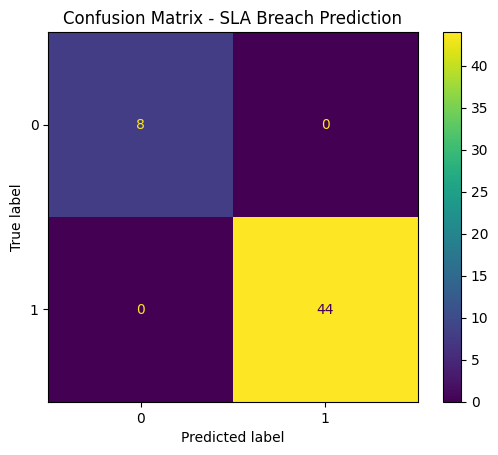

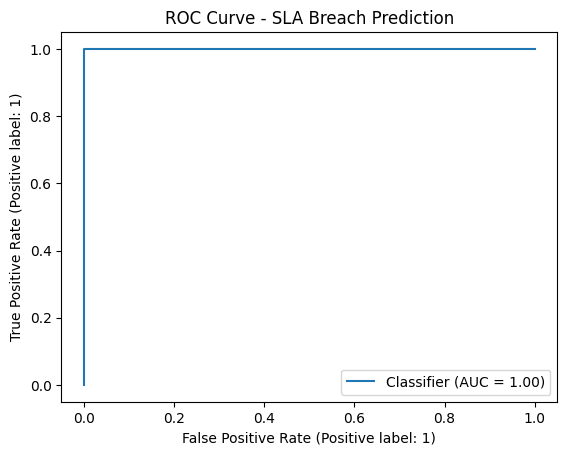

In [ ]:
# 5.3 Evaluate Classification Model
# **Evaluate the classification model** using accuracy, precision, recall, F1-score, ROC-AUC, and visualize the confusion matrix and ROC curve.
y_pred_clf = clf_pipeline.predict(X_test_clf)
y_proba_clf = clf_pipeline.predict_proba(X_test_clf)[:, 1]

# Metrics
acc = accuracy_score(y_test_clf, y_pred_clf)
prec = precision_score(y_test_clf, y_pred_clf)
rec = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)
auc = roc_auc_score(y_test_clf, y_proba_clf)

print("=== SLA Breach Classification Performance ===")
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))
print("ROC AUC  :", round(auc, 3))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - SLA Breach Prediction")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test_clf, y_proba_clf)
plt.title("ROC Curve - SLA Breach Prediction")
plt.show()


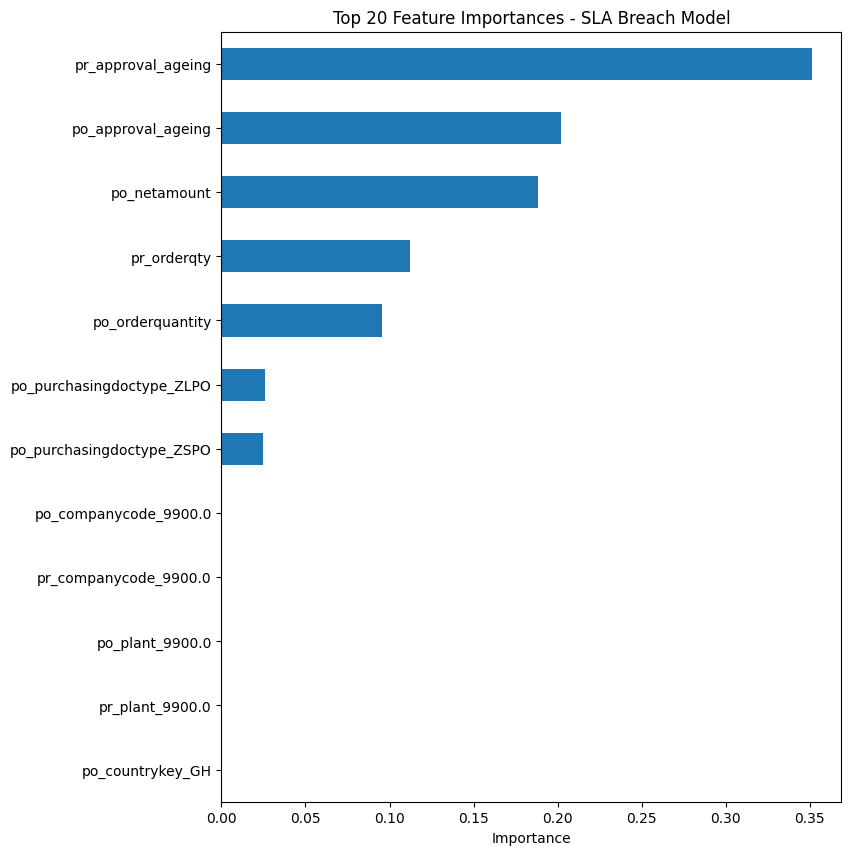

pr_approval_ageing           0.351358
po_approval_ageing           0.202056
po_netamount                 0.188176
pr_orderqty                  0.112170
po_orderquantity             0.095423
po_purchasingdoctype_ZLPO    0.026039
po_purchasingdoctype_ZSPO    0.024778
po_companycode_9900.0        0.000000
pr_companycode_9900.0        0.000000
po_plant_9900.0              0.000000
pr_plant_9900.0              0.000000
po_countrykey_GH             0.000000
dtype: float64

In [ ]:
# 5.4 Feature Importance (Classification)
# **Analyze feature importance** to see which company codes, plants, document types, and countries drive SLA breaches.
# Extract trained model & encoder
rf_model_clf = clf_pipeline.named_steps["model"]
ohe_clf = clf_pipeline.named_steps["preprocessor"].named_transformers_["cat"]

# Get feature names after OneHotEncoding
encoded_cat_features = list(ohe_clf.get_feature_names_out(categorical_features_clf))
all_feature_names_clf = encoded_cat_features + numeric_features_clf

importances_clf = rf_model_clf.feature_importances_
feat_imp_clf = pd.Series(importances_clf, index=all_feature_names_clf).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
feat_imp_clf.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances - SLA Breach Model")
plt.xlabel("Importance")
plt.show()

display(feat_imp_clf.head(20))


In [ ]:
# 6.0. Prepare Data for Regression
# **Prepare data for regression** to predict `pr_to_po_ageing` (PR→PO cycle time in business days).

# Keep only rows with a valid PR→PO ageing value
reg_df = df.dropna(subset=["pr_to_po_ageing"]).copy()

target_reg = "pr_to_po_ageing"

numeric_features_reg = [
    "pr_approval_ageing",
    "po_approval_ageing",
    "pr_orderqty",
    "po_orderquantity",
    "po_netamount"
]

categorical_features_reg = [
    "pr_companycode",
    "po_companycode",
    "pr_plant",
    "po_plant",
    "pr_documenttype",
    "po_purchasingdoctype",
    "po_purchasinggroup",
    "po_countrykey",
]

# 
reg_model_df = reg_df[numeric_features_reg + categorical_features_reg + [target_reg]].copy()

reg_model_df[numeric_features_reg] = reg_model_df[numeric_features_reg].fillna(0)
reg_model_df[categorical_features_reg] = reg_model_df[categorical_features_reg].fillna("Unknown")

X_reg = reg_model_df[numeric_features_reg + categorical_features_reg]
y_reg = reg_model_df[target_reg]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=42
)

print("Regression train shape:", X_train_reg.shape)
print("Regression test shape :", X_test_reg.shape)


Regression train shape: (208, 13)
Regression test shape : (52, 13)


In [ ]:
# 6.1 Build Regression Pipeline
# **Build and train a Random Forest regression model** using the same core features plus additional process attributes.
cat_transformer_reg = OneHotEncoder(handle_unknown="ignore")

preprocessor_reg = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer_reg, categorical_features_reg),
        ("num", "passthrough", numeric_features_reg)
    ]
)

rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_reg),
    ("model", rf_reg)
])

# Train
reg_pipeline.fit(X_train_reg, y_train_reg)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pr_companycode',
                                                   'po_companycode', 'pr_plant',
                                                   'po_plant',
                                                   'pr_documenttype',
                                                   'po_purchasingdoctype',
                                                   'po_purchasinggroup',
                                                   'po_countrykey']),
                                                 ('num', 'passthrough',
                                                  ['pr_approval_ageing',
                                                   'po_approval_ageing',
                                                   'pr_orderqty',
                                                   'po_orderquantity',
                                                   'po_netamount'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

=== PR→PO Ageing Regression Performance ===
MAE : 0.415 business days
RMSE: 1.661 business days
R²  : 0.989


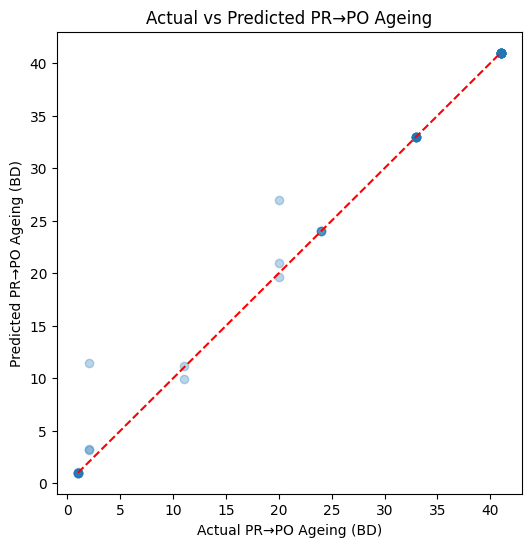

In [ ]:
# 6.2 Evaluate Regression Model
# **Evaluate the regression model** using MAE, RMSE, and R², and visualize actual vs predicted cycle times.
y_pred_reg = reg_pipeline.predict(X_test_reg)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print("=== PR→PO Ageing Regression Performance ===")
print("MAE :", round(mae, 3), "business days")
print("RMSE:", round(rmse, 3), "business days")
print("R²  :", round(r2, 3))

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         "r--")
plt.xlabel("Actual PR→PO Ageing (BD)")
plt.ylabel("Predicted PR→PO Ageing (BD)")
plt.title("Actual vs Predicted PR→PO Ageing")
plt.show()


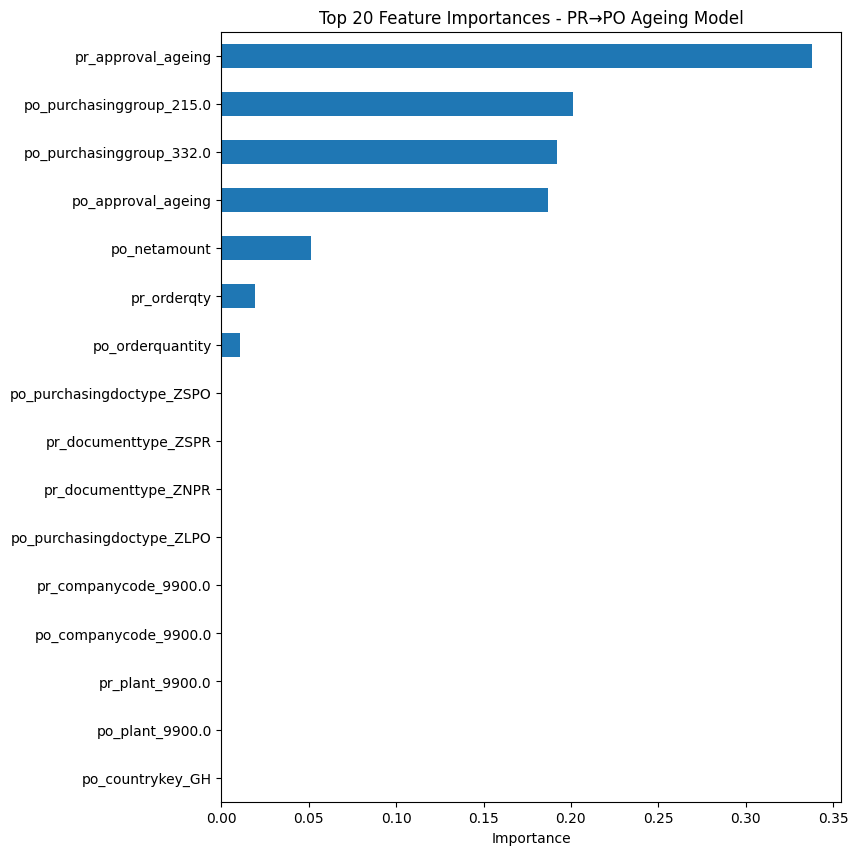

pr_approval_ageing           0.337950
po_purchasinggroup_215.0     0.201194
po_purchasinggroup_332.0     0.192254
po_approval_ageing           0.187141
po_netamount                 0.051439
pr_orderqty                  0.019438
po_orderquantity             0.010360
po_purchasingdoctype_ZSPO    0.000106
pr_documenttype_ZSPR         0.000067
pr_documenttype_ZNPR         0.000025
po_purchasingdoctype_ZLPO    0.000024
pr_companycode_9900.0        0.000000
po_companycode_9900.0        0.000000
pr_plant_9900.0              0.000000
po_plant_9900.0              0.000000
po_countrykey_GH             0.000000
dtype: float64

In [ ]:
# 6.3 Feature Importance (Regression)
rf_model_reg = reg_pipeline.named_steps["model"]
ohe_reg = reg_pipeline.named_steps["preprocessor"].named_transformers_["cat"]

encoded_cat_features_reg = list(ohe_reg.get_feature_names_out(categorical_features_reg))
all_feature_names_reg = encoded_cat_features_reg + numeric_features_reg

importances_reg = rf_model_reg.feature_importances_
feat_imp_reg = pd.Series(importances_reg, index=all_feature_names_reg).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
feat_imp_reg.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances - PR→PO Ageing Model")
plt.xlabel("Importance")
plt.show()

feat_imp_reg.head(20)


In [ ]:
#7.0  Display Result
# **Summarize results by business dimensions** (company code, plant, document type, vendor country) to provide insights that non-technical stakeholders can understand and use to support a 25% reduction in PR-to-PO cycle time.

print("Average PR→PO ageing by PO company code:")
display(df.groupby("po_companycode")["pr_to_po_ageing"].mean().sort_values(ascending=False))

print("\nAverage PR→PO ageing by PO plant:")
display(df.groupby("po_plant")["pr_to_po_ageing"].mean().sort_values(ascending=False).head(10))

print("\nAverage PR→PO ageing by PO document type:")
display(df.groupby("po_purchasingdoctype")["pr_to_po_ageing"].mean().sort_values(ascending=False))

print("\nAverage PR→PO ageing by vendor country:")
display(df.groupby("po_countrykey")["pr_to_po_ageing"].mean().sort_values(ascending=False).head(10))


Average PR→PO ageing by PO company code:


po_companycode
9900.0    29.669231
Name: pr_to_po_ageing, dtype: float64


Average PR→PO ageing by PO plant:


po_plant
9900.0    29.669231
Name: pr_to_po_ageing, dtype: float64


Average PR→PO ageing by PO document type:


po_purchasingdoctype
ZLPO    30.101562
ZSPO     2.000000
ZSCA          NaN
ZSEM          NaN
Name: pr_to_po_ageing, dtype: float64


Average PR→PO ageing by vendor country:


po_countrykey
GH    29.669231
NG          NaN
Name: pr_to_po_ageing, dtype: float64